Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0701
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7221e-04
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9942e-04
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5758e-04
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0520e-04
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5454e-04
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3690e-04
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9077e-04
Epoch 12/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1064e-04
Epoch 13/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8825e-04
Epoch 14/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7153e-04
Epoch 15/100
14

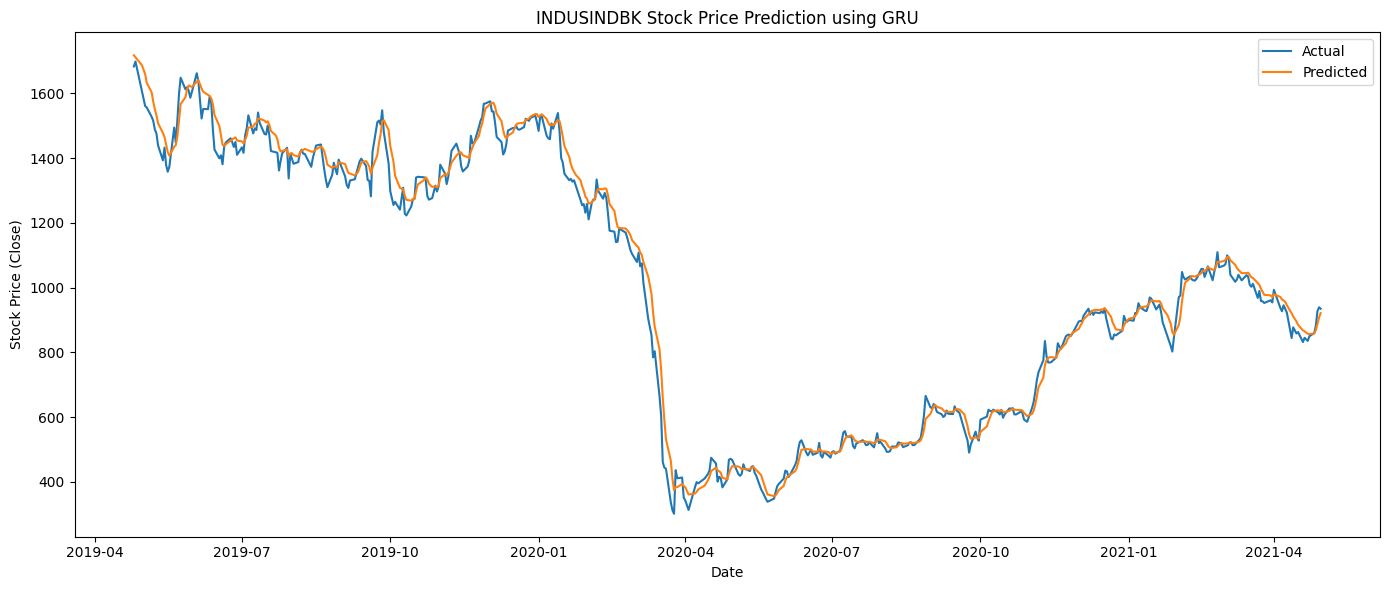

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Parameters to Tweak ---
MA_SPAN = 5
EMA_SPAN = 5
GRU_UNITS = 64
EPOCHS = 100
BATCH_SIZE = 32

# --- Load Data ---
df = pd.read_csv("/content/INDUSINDBK.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# --- Feature Engineering ---
df['MA'] = df['Close'].rolling(window=MA_SPAN).mean()
df['EMA'] = df['Close'].ewm(span=EMA_SPAN, adjust=False).mean()
df.dropna(inplace=True)

# --- Scaling ---
X = df[['MA', 'EMA']]
y = df[['Close']]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# --- Train-Test Split ---
split = int(len(X_scaled) * 0.9)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

# Reshape to [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# --- GRU Model ---
model = Sequential()
model.add(GRU(units=GRU_UNITS, return_sequences=False, input_shape=(1, X.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# --- Model Training ---
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# --- Prediction ---
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# --- Plotting ---
plt.figure(figsize=(14,6))
plt.plot(df.index[split:], y_test_actual, label='Actual')
plt.plot(df.index[split:], y_pred, label='Predicted')
plt.title("INDUSINDBK Stock Price Prediction using GRU")
plt.xlabel("Date")
plt.ylabel("Stock Price (Close)")
plt.legend()
plt.tight_layout()
plt.show()
